In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
# export
class TSMulti(MultiTuple):pass

## Transform catagorical data

In [7]:
# export
class TensorCatI(TensorBase):pass

class CatTfm(Transform):
    def __init__(self, df, cat_cols:[]): # maybe change to proccs
        self.vocab,self.o2i = {},{}
        for i, col in enumerate(L(cat_cols)):
            self.vocab[i], self.o2i[i] = uniqueify(list(df[col]), sort=True, bidir=True)
            
    def encodes(self, o:TensorCat):
        r = []
        for i in self.o2i:
            r.append(self.o2i[i][o.o[i]])            
        return TensorCatI(r, label = o._meta['label'])
    
    def decodes(self, o:TensorCatI): 
        r = []
        for i_cat in self.vocab:
            r.append(self.vocab[i_cat][o[i_cat]])
        return TensorCat(r, label = o._meta.get('label',None))
    
    

In [8]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a']))
test_eq(tmf.decode(o_tmf),TensorCat(['a']))

In [9]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b']))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b']))

In [10]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, *args, **kwargs): # maybe change to proccs
        self.f = CatTfm(*args, **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [11]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatMultiTfm(df,'a')
print(tmf)
o = TSMulti(TensorBase([1]), TensorCat('a'))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0])) )
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

CatMultiTfm: True (TSMulti,object) -> encodes (TSMulti_,object) -> decodes


# Dataloader

In [100]:
# export
def array2series(o):
    return pd.Series(o.flatten())
def arrays2series(s:pd.Series):
    return pd.Series([array2series(o) for o in s])

In [111]:
df = pd.DataFrame(data={'x':  [np.arange(10.),
                               np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [119]:
# hide
df = pd.DataFrame(data={'x':  [np.arange(10.)]*100,
                       'ts_0':[np.ones(10)[None,:]]*100,
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [157]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                o = arrays2series(df[col])
                self.dataset[col] = o
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], str):
                self.cat_names.append(col)
            elif isinstance(dataset[col].iloc[0], float) or isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        n = self.make_ids()
        kwargs.update({'after_item': CatMultiTfm(dataset, self.cat_names)})
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        if len(self.ts_names):
            tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
            tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        else:
            tsx = tensor(row[self.ts_names].to_numpy().astype(float))
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx, label=self.ts_names)]
        r.append(TensorCat(list(row[self.cat_names]), label=self.cat_names))
        # TODO make cat its own type
        r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name + '_y'], m=['g']))
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)  
        return TSMulti(r)    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [158]:
def get_df():
    return pd.DataFrame(data={'x':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':['a','b']
                       })
df = get_df()
df

,x,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.288879 1 1.539201 2 5.281625 3 3.086223 4 5.894492 5 6.276126 6 8.042800 7 8.512254 8 8.880545 9 8.340025 dtype: float64,0.0,a
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.092261 1 1.084942 2 3.210690 3 4.514244 4 5.010292 5 6.652420 6 7.185077 7 8.308707 8 9.228467 9 10.650184 10 11.377767 11 11.728580 dtype: float64,1.0,b


In [143]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)

for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break

Need to pad 1/2 time series due to length.


In [144]:
# hide
# without cat or con
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:,['x','ts_0']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [160]:
# hide
# without tsx
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:, ['x','var_0','con_0']], 'x', horizon = horizon, lookback = lookback, num_workers = 0)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([1]))
    test_eq(dct['con'].shape[1:], ([1]))
    test_eq(dct['tsx'].shape[1:], ([0]))
    
test_eq(first(dl), dl.one_batch())

In [18]:
# hide
# test self.new
dl.new()

# Showing

In [19]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

DfDataLoader.show_batch = _show_batch_class

In [20]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeqs, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i]])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x])
        ctx = o.show(ctx=ctx)
    return ctxs

In [21]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

Need to pad 1/2 time series due to length.


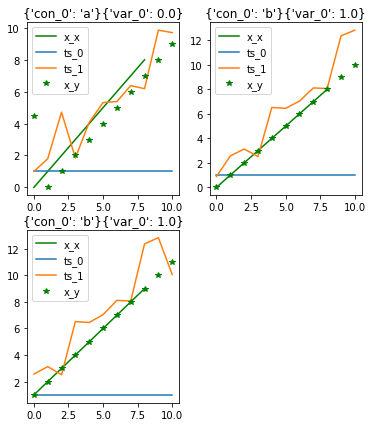

In [22]:
horizon,lookback = 2,9
df = pd.DataFrame(data={'x':[np.arange(10.),
                           np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                               pd.Series(np.arange(1,13)+np.random.randn(12))],
                       'var_0':[0.,1.],
                       'con_0':['a','b']
                       })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

In [25]:
# export

# def _show_results_class(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
#     x,y,its = self.show_batch(b, max_n=max_n, show=False,)
#     x = self.after_item.decode(b)
#     b_out = b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,))
#     x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
#     res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
#     if not show: return res
#     show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)
    
# DfDataLoader.show_results = _show_results_class

In [26]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i]] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [27]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [28]:
a = TensorSeqs([0], label = ['a'])
a._meta

{'label': ['a']}

Need to pad 1/2 time series due to length.
(#4) [0,222.4091796875,204.167724609375,'00:00']
Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.


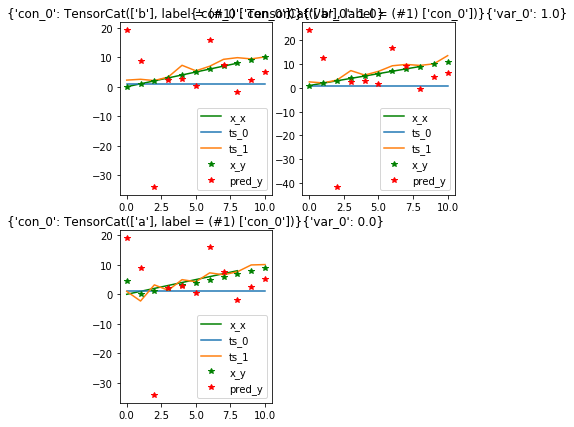

In [29]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

# Intergration Example

In [60]:
from fastseq.data.external import *

In [61]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city_int'] = df['city'].astype(int) 
df['city'] = df['city'].astype(float)
df.head()

,x,weather,city,cont,city_int
0,"[[-0.3166121469786813, -0.6157410168998708, -0.6312422017043872, -0.46223999014975475, -0.22710103279487265, 0.45381357824669033, 1.3331651055621832, 2.100157825323994, 2.457987408044388, 1.8356998181566104, 1.216147919702287, 0.5320574714475605, 0.30275643142334113, 0.04836544098966293, 0.40923907657083025, 0.21476133668164304, 0.625067145556258, 0.4718901862562137, 0.7815066548276371, 0.3431815021423211, -0.11036085837057553, -0.6530553468722116, -0.8628344224055949, -1.1842223639708482, -1.325059256408956, -1.444985987649168, -1.402569102495079, -0.9959910062109876, -0.5511331426353231,...","[[0.6114695989175378, 0.7361811173785376, 0.7915879056643907, 0.39864258456338286, -0.17331186356597517, -0.18477679330399177, 0.5985119590487864, 1.4501761136299427, 1.464253907290948, 0.6407453400318078, -0.11438782499893052, -0.07476730793891517, 0.5253427275124861, 0.946443635935494, 0.9191924349716638, 0.8226365038326904, 0.6114695989175378, 0.7361811173785376, 0.7915879056643907, 0.39864258456338286, -0.17331186356597517, -0.18477679330399177, 0.5985119590487864, 1.4501761136299427, 1.464253907290948, 0.6407453400318078, -0.11438782499893052, -0.07476730793891517, 0.5253427275124861,...",0.0,-0.549991,0
1,"[[-1.2110218316449324, -1.359931946067998, -0.2389900331824296, -0.4250635093138238, 0.5272063589066145, 0.3625913277253094, 0.2124060550718395, 0.6250340098743047, 1.1038129868911049, 0.9602964468797176, 1.5709901249557845, 0.564834894937818, 0.9511998486641828, 1.6742573561381624, 1.3221271867557896, 1.0228352841717836, -0.6203354836180426, -1.3411146533635308, -0.8383604665336504, -1.1044487137292842, -1.364119405292368, -1.8168184533832434, -1.7648526024363784, -1.3618035238842645, -0.17142960987881387, 0.5861201149822453, 0.9660825779745628, 0.1501970222219706, 0.05917238490435739, 0....","[[7.620693663652048, 7.260178482153272, 8.236714304836195, 9.883874159019925, 10.444147100066335, 9.384163760665562, 8.105210345480549, 8.07986624554501, 8.954191644338959, 9.175487701019463, 8.22500433231925, 7.355038207651091, 7.837395104445323, 9.186356192756039, 9.838335814570694, 9.339367801319801, 7.620693663652048, 7.260178482153272, 8.236714304836195, 9.883874159019925, 10.444147100066335, 9.384163760665562, 8.105210345480549, 8.07986624554501, 8.954191644338959, 9.175487701019463, 8.22500433231925, 7.355038207651091, 7.837395104445323, 9.186356192756039, 9.838335814570694, 9.33936...",0.0,1.654291,0
2,"[[0.6388635081846932, 0.30146489575776536, 0.051094929826662826, 0.258955038761495, 0.6057024474717708, 1.4928325343290036, 2.113758347295914, 2.1306895096426213, 1.9085681115835962, 1.3119992908333509, 0.7669226758621221, 0.3080792240904457, 0.04576931304829385, -0.3372337821975694, -0.45081622756883466, -0.48329610104039467, 0.1677116411120068, 0.11972084297412716, -0.08315651131268034, 0.08808554237258341, -0.09726326939839684, -0.5528620711715287, -0.9586104012392135, -1.5285134477633937, -1.566795182767885, -1.8227784915135241, -1.2434003506570313, -0.840555256963947, -0.4730140874325...","[[7.194696099853175, 6.886328375237439, 6.999311339025963, 7.40827234279642, 7.835623683927674, 8.031130223976856, 7.767612079031286, 6.904638338319414, 5.628787277335696, 4.550265362266194, 4.334256642856035, 5.104875759179306, 6.262740276021552, 6.9899671536449866, 6.953937628484657, 6.496380201903988, 7.194696099853175, 6.886328375237439, 6.999311339025963, 7.40827234279642, 7.835623683927674, 8.031130223976856, 7.767612079031286, 6.904638338319414, 5.628787277335696, 4.550265362266194, 4.334256642856035, 5.104875759179306, 6.262740276021552, 6.9899671536449866, 6.953937628484657, 6.496...",0.0,-0.147860,0
3,"[[1.5116449780675019, 1.0680177049715707, 1.077897006511979, 1.1802291324004253, 1.921519946571289, 1.8202197090659484, 1.6585495432737645, 0.7122787333602755, -0.05782718895508817, -0.6404546780396811, -0.7921658251689216, -0.2576384287587261, -0.07968354038086779, -0.2746244636249155, 0.037801076994

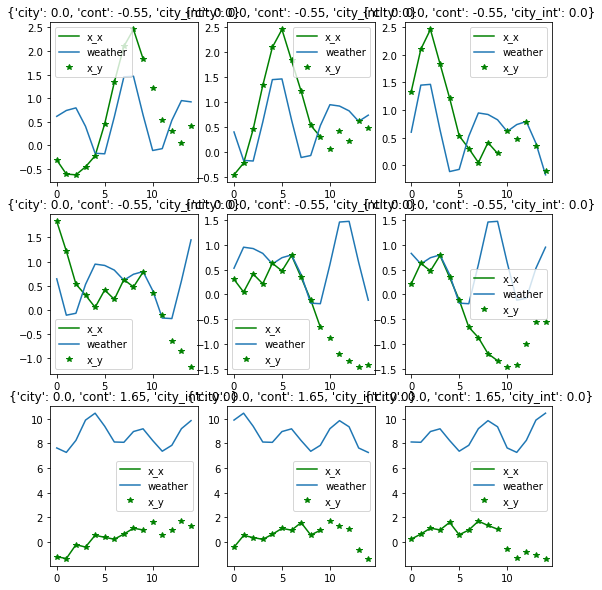

In [62]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

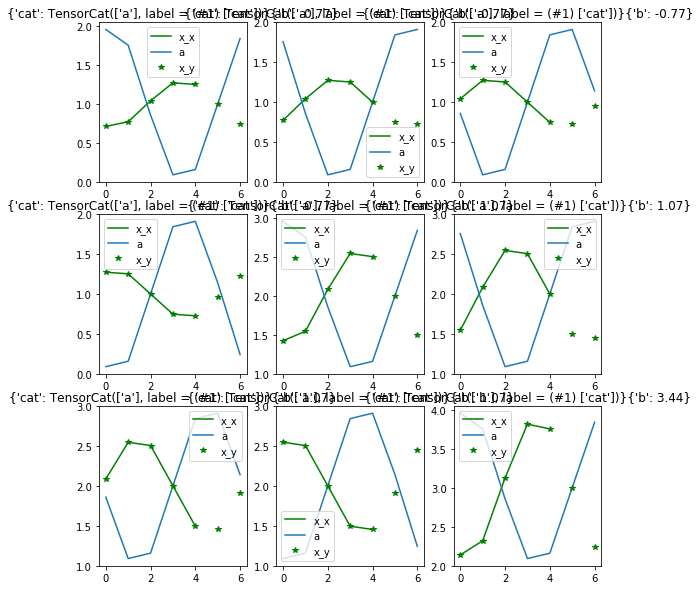

In [68]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
#                   after_batch = NormalizeTSMulti(),
                  num_workers = 1)
dl.show_batch()

# M5 Example

In [23]:
path = Path('../data/m5')
path.ls()

(#8) [Path('../data/m5/sales_train_validation.csv'),Path('../data/m5/M5-Competitors-Guide_Final-1.pdf'),Path('../data/m5/sample_submission.csv'),Path('../data/m5/Screenshot from 2020-03-04 13-24-55.png'),Path('../data/m5/calendar.csv'),Path('../data/m5/m5-forecasting-accuracy.zip'),Path('../data/m5/Screenshot from 2020-03-04 13-25-42.png'),Path('../data/m5/sell_prices.csv')]

In [24]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [43]:
def _to_series(df):
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:].values.astype(float)))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = pd.Series(_to_series(df))
    df = pd.DataFrame(data=data)
    return df
df_sales_s = to_contained_series(df_sales)

In [44]:
dl =  DfDataLoader(df_sales_s, 'sales', horizon = 28, lookback=28*3, step=2)
dl.show_batch(max_n=9)

ValueError: need at least one array to concatenate

In [107]:
df_prices = pd.read_csv(path / 'sell_prices.csv')
df_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [106]:
df_cal = pd.read_csv(path / 'calendar.csv')
df_cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
